# Use ARIMA model to predict close prices

### Importing necessary packages

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns # for visualization
from statsmodels.tsa.stattools import adfuller #for the dickey-fuller test necessary for the ARIMA model
from statsmodels.tsa.stattools import acf, pacf # for the ACF and PACF
from statsmodels.tsa.arima_model import ARIMA # for ARIMA 

# Regressors stuff
import sklearn
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor

### Create a datetime index

In [7]:
"""
dateparse = lambda dates: pd.datetime.strptime(dates, "%Y/%m/%d")
apple = pd.read_csv("HistoricalQuotes.csv", index_col= "date", date_parser = dateparse)
apple.head()
"""
apple = pd.read_csv("HistoricalQuotes.csv", index_col="date")
apple.index = pd.to_datetime(apple.index, format = "%Y/%m/%d")
apple.head()

,close,volume,open,high,low
date,,,,,
2017-11-10,174.67,25129510.0,175.110,175.380,174.27
2017-11-09,175.88,29422610.0,175.110,176.095,173.14
2017-11-08,176.24,24358920.0,174.660,176.240,174.33
2017-11-07,174.81,24332120.0,173.910,175.250,173.60
2017-11-06,174.25,34770480.0,172.365,174.990,171.72


In [4]:
apple.index

DatetimeIndex(['2017-11-10', '2017-11-09', '2017-11-08', '2017-11-07',
               '2017-11-06', '2017-11-03', '2017-11-02', '2017-11-01',
               '2017-10-31', '2017-10-30',
               ...
               '2012-11-26', '2012-11-23', '2012-11-21', '2012-11-20',
               '2012-11-19', '2012-11-16', '2012-11-15', '2012-11-14',
               '2012-11-13', '2012-11-12'],
              dtype='datetime64[ns]', name='date', length=1260, freq=None)

In [10]:
ts = apple["close"]
ts.head()

date
2017-11-10    174.67
2017-11-09    175.88
2017-11-08    176.24
2017-11-07    174.81
2017-11-06    174.25
Name: close, dtype: float64

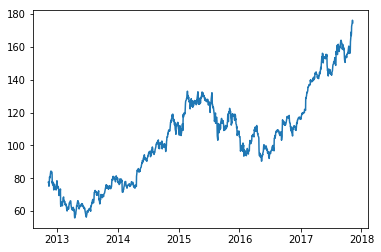

In [11]:
plt.plot(ts)
plt.show()

### Test Stationarity for ARIMA Model

In [24]:
def test_stationarity(timeseries): 
    # rolling stats
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    #plot 
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # dickey fuller
    print("Results of Dickey Fuller Test: ")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

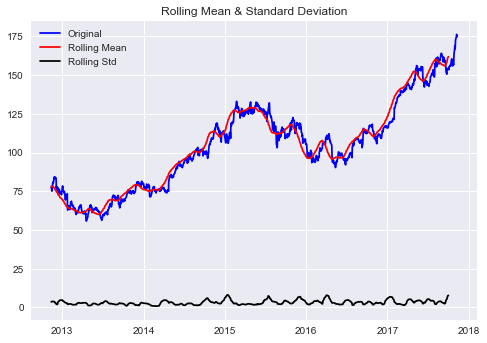

Results of Dickey Fuller Test: 
Test Statistic                   -2.350539
p-value                           0.156186
#Lags Used                        0.000000
Number of Observations Used    1259.000000
Critical Value (1%)              -3.435555
Critical Value (5%)              -2.863838
Critical Value (10%)             -2.567994
dtype: float64


In [25]:
test_stationarity(ts)

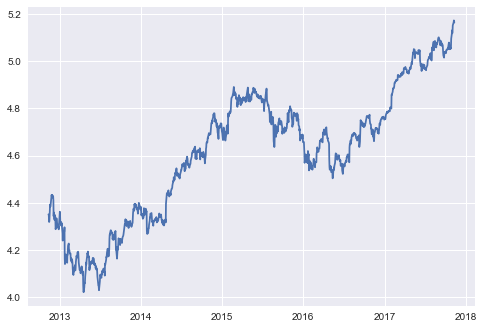

In [26]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

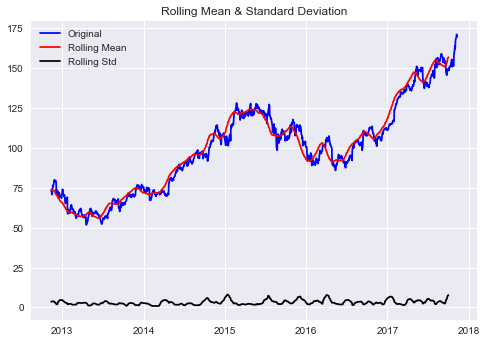

Results of Dickey Fuller Test: 
Test Statistic                   -2.356693
p-value                           0.154334
#Lags Used                        0.000000
Number of Observations Used    1259.000000
Critical Value (1%)              -3.435555
Critical Value (5%)              -2.863838
Critical Value (10%)             -2.567994
dtype: float64


In [27]:
ts_log_diff = ts - ts_log
test_stationarity(ts_log_diff)

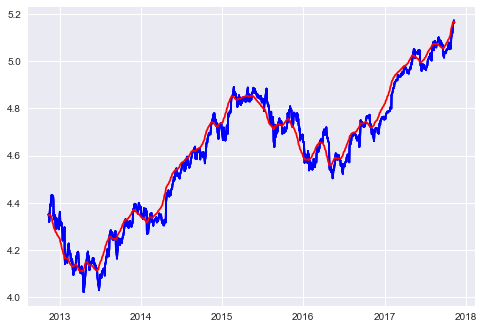

In [35]:
expweighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log, color = "blue")
plt.plot(expweighted_avg, color = "red")
plt.show()

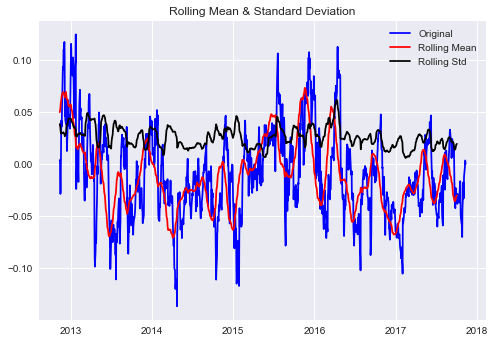

Results of Dickey Fuller Test: 
Test Statistic                -5.680823e+00
p-value                        8.494430e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.251000e+03
Critical Value (1%)           -3.435588e+00
Critical Value (5%)           -2.863853e+00
Critical Value (10%)          -2.568002e+00
dtype: float64


In [36]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)

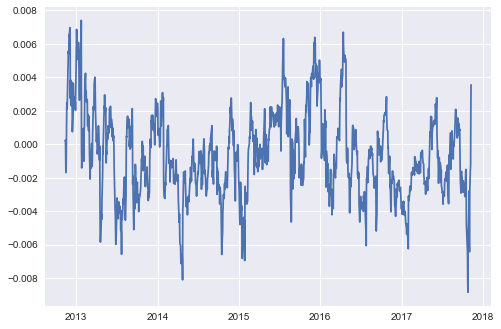

In [37]:
ts_log_ewma_diff = expweighted_avg - expweighted_avg.shift()
plt.plot(ts_log_ewma_diff)
plt.show()

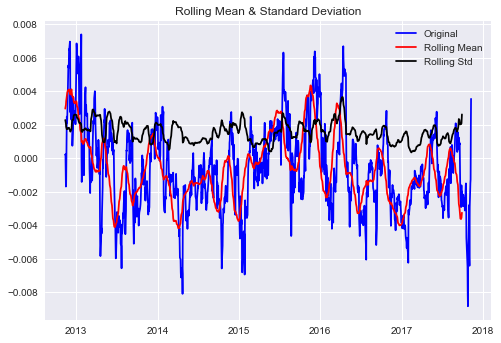

Results of Dickey Fuller Test: 
Test Statistic                -5.831146e+00
p-value                        3.972481e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


In [38]:
ts_log_ewma_diff.dropna(inplace = True)
test_stationarity(ts_log_ewma_diff)

### ACF and PACF graphs

In [40]:
lag_acf = acf(ts_log_ewma_diff, nlags = 20)
lag_pacf = pacf (ts_log_ewma_diff, nlags = 20, method = 'ols')

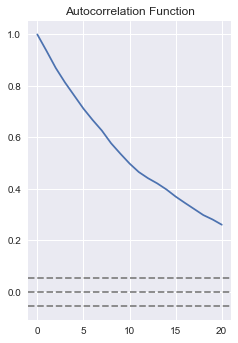

In [41]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

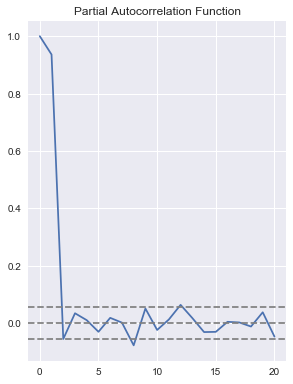

In [42]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

# ARIMA model

C:\Users\veena\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\veena\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


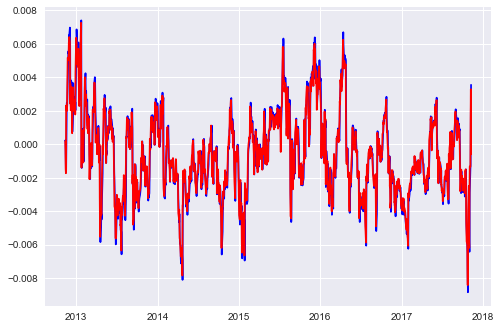

In [53]:
model = ARIMA(expweighted_avg, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_ewma_diff, color = 'blue')
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.show()

In [54]:
sum((results_ARIMA.fittedvalues-ts_log_ewma_diff)**2)

0.001016440453548702

In [55]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

date
2017-11-09   -0.000593
2017-11-08    0.003291
2017-11-07    0.001647
2017-11-06   -0.001346
2017-11-03   -0.001326
dtype: float64

In [56]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

date
2017-11-09   -0.000593
2017-11-08    0.002698
2017-11-07    0.004345
2017-11-06    0.002999
2017-11-03    0.001673
dtype: float64

In [57]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\veena\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2012-11-12    4.350844
2012-11-13    4.350657
2012-11-14    4.350995
2012-11-15    4.352497
2012-11-16    4.354229
dtype: float64

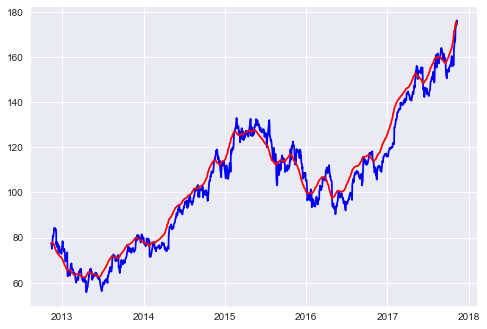

In [58]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts, color = "blue")
plt.plot(predictions_ARIMA, color = "red")
plt.show()

# Analyzing Trends using Random Forest Regressor

In [59]:
trends = pd.read_csv("multiTimeline.csv")

In [60]:
trends.head()

,Week,Trend
0,11/18/2012,47
1,11/25/2012,42
2,12/2/2012,41
3,12/9/2012,42
4,12/16/2012,42


In [64]:
dateparse_trends = lambda dates: pd.datetime.strptime(dates, "%m/%d/%Y")
trends = pd.read_csv("multiTimeline.csv", index_col= "Week", date_parser = dateparse_trends)

In [65]:
trends.index

DatetimeIndex(['2012-11-18', '2012-11-25', '2012-12-02', '2012-12-09',
               '2012-12-16', '2012-12-23', '2012-12-30', '2013-01-06',
               '2013-01-13', '2013-01-20',
               ...
               '2017-09-03', '2017-09-10', '2017-09-17', '2017-09-24',
               '2017-10-01', '2017-10-08', '2017-10-15', '2017-10-22',
               '2017-10-29', '2017-11-05'],
              dtype='datetime64[ns]', name='Week', length=260, freq=None)

In [66]:
trend = trends["Trend"]

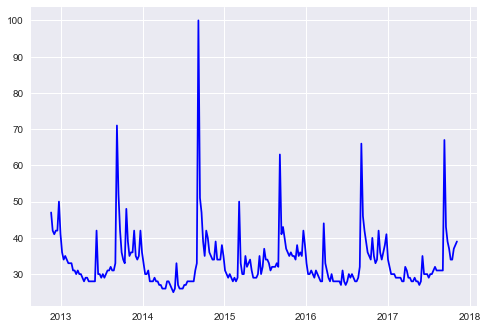

In [67]:
plt.plot(trend, color = "blue")
plt.show()

In [68]:
dateparse_weekly = lambda dates: pd.datetime.strptime(dates, "%m/%d/%Y")
weekly = pd.read_csv("AAPL.csv", index_col = "Date", date_parser = dateparse_weekly)

In [69]:
weekly.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-11-19,77.244286,81.714287,77.125717,81.642860,73.837326,527975000
2012-11-26,82.271431,84.892860,81.751427,83.611427,75.617699,647698100
2012-12-03,84.807144,84.941429,74.089996,76.178574,68.895454,982559900
2012-12-10,75.000000,78.508568,72.225716,72.827141,65.864456,836203200
2012-12-17,72.704285,76.414284,71.604286,74.190002,67.097015,727654900


In [70]:
prices = weekly["Open"]

In [71]:
trends["prices"] = prices.values

In [72]:
y = trends["prices"]
x = trends.drop("prices", axis = 1)
trends

,Trend,prices
Week,,
2012-11-18,47,77.244286
2012-11-25,42,82.271431
2012-12-02,41,84.807144
2012-12-09,42,75.000000
2012-12-16,42,72.704285
2012-12-23,50,74.335716
2012-12-30,41,72.932854
2013-01-06,36,74.571426
2013-01-13,34,71.811432


In [75]:
train, test = train_test_split (trends, test_size = 0.2)
train_x = train.drop("prices", 1)
train_y = train["prices"]
test_x = test.drop("prices", 1)
test_y = test ["prices"]

In [41]:
forest = RandomForestRegressor()
forest.fit(train_x, train_y)
forest_predictions = forest.predict(test_x)

In [54]:
d = {"Predictions":forest_predictions, "Actual": test_y}
df = pd.DataFrame(data = d)
df.sort_index(inplace = True)

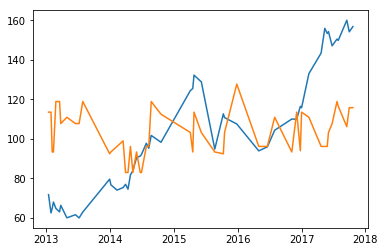

In [56]:
plt.plot(df["Actual"])
plt.plot(df["Predictions"])
plt.show()